In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 


from inference import Trajectory
from plotting import *
from models.two_species_ss import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmasher as cmr

# Generate data

In [65]:
np.random.seed(0)
loga_max = 4
logb_max = 2

n=1000
p=100
topo = np.array([[0,1,2],[0,1,3]])
tau = (0,1,2)

L=len(topo)
n_states=len(set(topo.flatten()))
t=np.linspace(tau[0],tau[-1],n)
true_t = []

theta=np.zeros((p,n_states+2))
for j in range(n_states):
    theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2:]=np.exp(np.random.uniform(0,logb_max,size=(p,2)))

Y = np.zeros((n*L,p,2))
for l in range(L):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
    Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
    true_t = np.append(true_t,t)

X = np.random.poisson(Y)

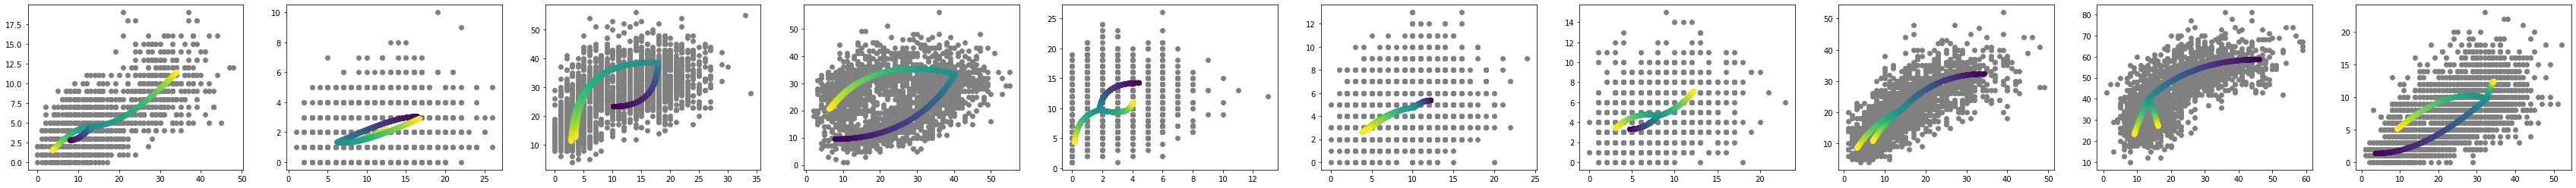

In [66]:
t = np.linspace(tau[0],tau[-1],n)
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t)
    #ax[i].scatter(Y[n:,i,0],Y[n:,i,1],c=true_t[n:],cmap=cmap_2, vmin=tau[0], vmax=tau[-1]);
    #ax[i].scatter(Y[:n//2,i,0],Y[:n//2,i,1],c=t[:n//2],cmap="Purples", vmin=tau[0], vmax=tau[-1]);
# time increases from blue to red

# PCA

In [67]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,m=100,n_init=10,perm_theta=False,epoch=10,parallel=True,n_threads=4)

run method fit_multi_init
trial 1


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

trial 2



100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

trial 3



100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

trial 4



100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

trial 5



100%|██████████| 10/10 [00:13<00:00,  1.31s/it]

trial 6



100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

trial 7



100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

trial 8



100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

trial 9



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

trial 10



100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:,:,1])

theta_hat = traj.theta.copy()
_,L,m = traj.Q.shape
Y_pca = np.zeros((L,n,2))
t_hat=np.linspace(tau[0],tau[-1],n)
Y = traj.get_Y_hat(theta_hat,t_hat,traj.tau,traj.topo,traj.params) # m*p*2
for l in range(L):
    Y_pca[l] = pca.transform(Y[l,:,:,1])

In [89]:
cmap_1 = cmr.get_sub_cmap('Blues', 0.1, 0.9)
cmap_2 = cmr.get_sub_cmap('Reds', 0.1, 0.9)
cmap_3 = cmr.get_sub_cmap('Greens', 0.1, 0.9)

In [91]:
color_1 = traj.Q[:,0]@np.array(cmap_1(traj.t/tau[-1]))[:,:3]
color_2 = traj.Q[:,1]@np.array(cmap_2(traj.t/tau[-1]))[:,:3]
t_color = color_1 + color_2

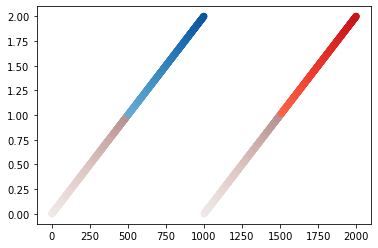

In [71]:
plt.scatter(np.arange(n*2),true_t,c=t_color[:,:3]);

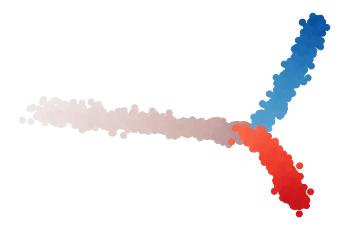

In [72]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_pca[:,0],X_pca[:,1],c=t_color[:,:3]);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

# Genes plots

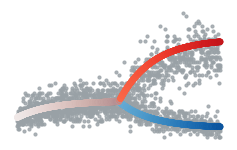

In [117]:
i=0
x = X[:,i]
x_weighted = np.zeros((L,m,2))

for l in range(len(topo)):
    weight_l = traj.Q[:,l,:]/n*m
    x_weighted[l] = weight_l.T@x / weight_l.sum(axis=0)[:,None] # m*1
    
fig = plt.figure(figsize=(4,2.5))
plt.scatter(true_t,X[:,i,0],color="#99a1a6",alpha=0.8,s=10);
#plt.scatter(traj.t,x_weighted[0,:,0],color="#d3d3d3",alpha=0.8,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:],s=30);
plt.axis('off');

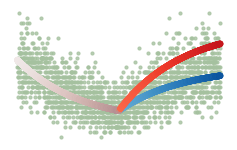

In [116]:
i=1
fig = plt.figure(figsize=(4,2.5))
plt.scatter(true_t,X[:,i,0],color="#a5c19f",alpha=0.8,s=10);
#plt.scatter(traj.t,x_weighted[0,:,0],color="#d3d3d3",alpha=0.8,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:],s=30);
plt.axis('off');

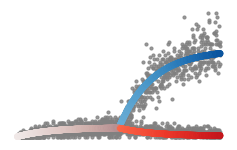

In [120]:
i=-1
fig = plt.figure(figsize=(4,2.5))
plt.scatter(true_t,X[:,i,0],color="gray",alpha=0.8,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n,:3],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:,:3],s=30);
plt.axis('off');